In [111]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [112]:
from pymongo import MongoClient
from datetime import datetime
client = MongoClient('52.79.241.214', 27017)
print("DB connection complete!!")
DB_Coin = client["Coin-USD"] 

DB connection complete!!


In [453]:
Collection = DB_Coin['BTC']
import time
DB_schema = []
i = 0

for collect in Collection.find():
    #if i==2902:
    if i==502:
        continue
    temp_record = {}
    temp_record['open'] = collect['Open']
    temp_record['close'] = collect['Price']
    temp_record['high'] = collect['High']
    temp_record['low'] = collect['Low']
    temp_record['volume'] = collect['Volume']    
    temp_record['Date'] = collect['Date']
    DB_schema.append(temp_record)
    del temp_record
    i = i+1
first_date=DB_schema[0]['Date']
print(first_date)
first_date=str(first_date)
last_date=DB_schema[-1]['Date']
print(last_date)
last_date=str(last_date)

20180807
20170324


In [454]:
import pandas as pd
hash_rate=pd.read_csv('D:/export-NetworkHash.csv',header=None)
hash_rate=hash_rate.shift(-1)
hash_rate_from=hash_rate[(hash_rate[0]=='20170324')]
hash_rate_to=hash_rate[(hash_rate[0]=='20180807')]
hash_rate_from_index=hash_rate_from.index[0]
hash_rate_to_index=hash_rate_to.index[0]
hash_rate=hash_rate.iloc[hash_rate_from_index:hash_rate_to_index+1,0:2]
hash_rate=hash_rate[1]
hash_rate=hash_rate.sort_index(ascending=False)      ## according to the order of from 20180808 to 20170324
hash_rate=list(hash_rate)

In [455]:
import pandas as pd
page_views=pd.read_csv('D:/pageviews.csv',header=None)
page_views=page_views.shift(-1)
page_views_from=page_views[(page_views[0]=='20170324')]
page_views_to=page_views[(page_views[0]=='20180807')]
page_views_from_index=page_views_from.index[0]
page_views_to_index=page_views_to.index[0]
page_views=page_views.iloc[page_views_from_index:page_views_to_index+1,0:2]
page_views=page_views[1]
page_views=page_views.sort_index(ascending=False)      ## according to the order from 20180808 to 20170324
page_views=list(page_views)

### issue

In [456]:
%matplotlib inline
import pandas as pd
DF = pd.DataFrame(DB_schema)
DF.index = DF['Date']
DF.loc[:,'page_views']=page_views
DF.loc[:,'hash_rate']=hash_rate

In [146]:
DF.values.shape

(502, 8)

In [457]:
target_names = ['close']
shift_hours = 2
DF_targets = DF[target_names].shift(-shift_hours)

In [458]:
DF = DF[['close', 'high', 'low', 'open', 'volume','page_views','hash_rate']]
DF.head()

,close,high,low,open,volume,page_views,hash_rate
Date,,,,,,,
20180807,6952.3,6991.6,6914.8,6943.6,157830.0,16708,291954.5748
20180806,6943.6,7143.6,6852.5,7027.8,168870.0,16035,293327.109
20180805,7027.1,7087.6,6887.9,7014.0,177640.0,11327,293048.5066
20180804,7014.3,7484.2,6949.7,7418.9,222570.0,11066,292889.4426
20180803,7419.0,7535.6,7293.5,7535.6,226460.0,14465,285672.7276


In [459]:
DF_targets.head()

,close
Date,
20180807,7027.1
20180806,7014.3
20180805,7419.0
20180804,7535.6
20180803,7606.4


In [460]:
Diff_y_data = np.diff(DF_targets.values, axis=0)
y_data=DF_targets.values[:-1]
Diff_y_data=Diff_y_data/y_data
Movement = []

Grad=0.02   # 기준점
for i in range(Diff_y_data.shape[0]):
    if Diff_y_data[i][0] > Grad:
        Movement.append(1)   # 상승
    elif Diff_y_data[i][0] < -Grad:
        Movement.append(-1)  # 하락
    else:
        Movement.append(0)   # 보합
        
del Diff_y_data
y_data = np.array(Movement)  # list to np.array

from tensorflow.python.keras.utils import to_categorical
y_true_movement = to_categorical(y_data, num_classes=3) # one-hot encoding으로 변환한다

print(y_true_movement)

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [461]:
x_data = DF.values[0:-shift_hours]
print(type(x_data))
print("Shape: ", x_data.shape)

<class 'numpy.ndarray'>
Shape:  (500, 7)


In [462]:
y_data = DF_targets.values[:-shift_hours]
print(type(y_data))
print("Shape: ", y_data.shape)

<class 'numpy.ndarray'>
Shape:  (500, 1)


In [463]:
num_data = len(x_data)
train_split = 0.6
num_train = int(train_split * num_data)
num_test = num_data - num_train

In [464]:
print(num_train)
print(num_test)

300
200


In [465]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
num_x_signals = x_data.shape[1]
num_y_signals = y_data.shape[1]

In [466]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)  # 데이터의 크기를 0에서 1사이로 조정
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [467]:
x_test_scaled = x_scaler.transform(x_test)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Adjust the input data with Autoencoder Function

In [468]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K


############################################################################# ???
#def Auto_encoder_cost(X_input, H_Layer, X_reconstructed, W_ih, W_hr):
    ############# Hyper-parameter #############
#    param_sparsity = 0.01
#    Lambda = 0.0001 # param_weight_decay
#   Beta = 3 # param_sparse_panelty
    ###########################################
    
#    average_act_hidden = tf.reduce_mean(H_Layer,axis=0)   #Average hidden layer over all data points in X, Page 14 in https://web.stanford.edu/class/cs294a/sparseAutoencoder_2011new.pdf
#    diff = X_input - X_reconstructed
#    KL = Kullback_Leibler_divergence(param_sparsity, average_act_hidden)
#    cost= 0.5*tf.reduce_mean(tf.reduce_sum(tf.pow(diff,2),axis=1)) + 0.5*Lambda*(tf.nn.l2_loss(W_ih) + tf.nn.l2_loss(W_hr)) + Beta*tf.reduce_sum(KL)
#    return cost

#def Kullback_Leibler_divergence(rho, rho_hat):
#    return rho * tf.log(rho) - rho * tf.log(rho_hat) + (1 - rho) * tf.log(1 - rho) - (1 - rho) * tf.log(1 - rho_hat) 


def Single_Layer_Autoencoder(input_dim, encoding_dim=4):
    
    # this is our input placeholder
    input_encode = Input(shape=(input_dim,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='sigmoid')(input_encode)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    # this model maps an input to its reconstruction
    autoencoder = Model(input_encode, decoded)
    autoencoder.compile(optimizer='sgd', loss='mse')
    return autoencoder


def Get_layer_values(model, layer_idx):
    get_values = K.function([model.layers[0].input], [model.layers[layer_idx].output])
    tf.Print(get_values([0])[0])
    return get_values([x])[0]
    
autoencoder1 = Single_Layer_Autoencoder(7, 4)
print(x_train_scaled)
autoencoder1.fit(x_train_scaled, x_train_scaled, nb_epoch=20, batch_size=16)
autoencoder1_hidden = autoencoder1.predict(x_train_scaled)

autoencoder2 = Single_Layer_Autoencoder(7, 4)
autoencoder2.fit(autoencoder1_hidden, autoencoder1_hidden, nb_epoch=20, batch_size=16)
autoencoder2_hidden = autoencoder2.predict(autoencoder1_hidden)


autoencoder3 = Single_Layer_Autoencoder(7, 4)
autoencoder3.fit(autoencoder2_hidden, autoencoder2_hidden, nb_epoch=20, batch_size=16)
autoencoder3_hidden = autoencoder3.predict(autoencoder2_hidden)

autoencoder4 = Single_Layer_Autoencoder(7, 4)
autoencoder4.fit(autoencoder3_hidden, autoencoder3_hidden, nb_epoch=20, batch_size=16)
autoencoder4_output = autoencoder4.predict(autoencoder3_hidden)


[[0.10922956 0.10797894 0.15067559 ... 0.12547232 0.02537754 0.99270671]
 [0.10860424 0.11850672 0.14620512 ... 0.13871529 0.02337765 1.        ]
 [0.11460587 0.11462806 0.14874533 ... 0.14923529 0.00938731 0.99851958]
 ...
 [0.02818248 0.0281895  0.05409769 ... 0.02757752 0.09704384 0.        ]
 [0.01471296 0.02910375 0.04140386 ... 0.19407425 0.13561236 0.02611085]
 [0.         0.         0.         ... 0.13277754 0.11045472 0.00166466]]
Epoch 1/20


D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:44: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


300/300 [==============================] - 1s 5ms/step - loss: 0.0968
Epoch 2/20
300/300 [==============================] - 0s 53us/step - loss: 0.0961
Epoch 3/20
300/300 [==============================] - 0s 50us/step - loss: 0.0954
Epoch 4/20
300/300 [==============================] - 0s 47us/step - loss: 0.0947
Epoch 5/20
300/300 [==============================] - 0s 50us/step - loss: 0.0940
Epoch 6/20
300/300 [==============================] - 0s 47us/step - loss: 0.0933
Epoch 7/20
300/300 [==============================] - 0s 47us/step - loss: 0.0927
Epoch 8/20
300/300 [==============================] - 0s 50us/step - loss: 0.0920
Epoch 9/20
300/300 [==============================] - 0s 50us/step - loss: 0.0914
Epoch 10/20
300/300 [==============================] - 0s 47us/step - loss: 0.0907
Epoch 11/20
300/300 [==============================] - 0s 46us/step - loss: 0.0901
Epoch 12/20
300/300 [==============================] - 0s 47us/step - loss: 0.0895
Epoch 13/20
300/300 [====

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:48: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/20
300/300 [==============================] - 1s 5ms/step - loss: 0.0073
Epoch 2/20
300/300 [==============================] - 0s 50us/step - loss: 0.0072
Epoch 3/20
300/300 [==============================] - 0s 53us/step - loss: 0.0071
Epoch 4/20
300/300 [==============================] - 0s 50us/step - loss: 0.0070
Epoch 5/20
300/300 [==============================] - 0s 50us/step - loss: 0.0069
Epoch 6/20
300/300 [==============================] - 0s 50us/step - loss: 0.0068
Epoch 7/20
300/300 [==============================] - 0s 47us/step - loss: 0.0068
Epoch 8/20
300/300 [==============================] - 0s 50us/step - loss: 0.0067
Epoch 9/20
300/300 [==============================] - 0s 46us/step - loss: 0.0066
Epoch 10/20
300/300 [==============================] - 0s 47us/step - loss: 0.0065
Epoch 11/20
300/300 [==============================] - 0s 47us/step - loss: 0.0064
Epoch 12/20
300/300 [==============================] - 0s 47us/step - loss: 0.0064
Epoch 13/20
30

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:53: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/20
300/300 [==============================] - 1s 5ms/step - loss: 0.0185
Epoch 2/20
300/300 [==============================] - 0s 50us/step - loss: 0.0183
Epoch 3/20
300/300 [==============================] - 0s 47us/step - loss: 0.0181
Epoch 4/20
300/300 [==============================] - 0s 53us/step - loss: 0.0179
Epoch 5/20
300/300 [==============================] - 0s 53us/step - loss: 0.0176
Epoch 6/20
300/300 [==============================] - 0s 53us/step - loss: 0.0174
Epoch 7/20
300/300 [==============================] - 0s 53us/step - loss: 0.0172
Epoch 8/20
300/300 [==============================] - 0s 50us/step - loss: 0.0170
Epoch 9/20
300/300 [==============================] - 0s 50us/step - loss: 0.0167
Epoch 10/20
300/300 [==============================] - 0s 47us/step - loss: 0.0165
Epoch 11/20
300/300 [==============================] - 0s 50us/step - loss: 0.0163
Epoch 12/20
300/300 [==============================] - 0s 46us/step - loss: 0.0161
Epoch 13/20
30

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:57: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/20
300/300 [==============================] - 1s 5ms/step - loss: 0.0274
Epoch 2/20
300/300 [==============================] - 0s 50us/step - loss: 0.0271
Epoch 3/20
300/300 [==============================] - 0s 53us/step - loss: 0.0267
Epoch 4/20
300/300 [==============================] - 0s 50us/step - loss: 0.0263
Epoch 5/20
300/300 [==============================] - 0s 47us/step - loss: 0.0259
Epoch 6/20
300/300 [==============================] - 0s 47us/step - loss: 0.0256
Epoch 7/20
300/300 [==============================] - 0s 47us/step - loss: 0.0252
Epoch 8/20
300/300 [==============================] - 0s 43us/step - loss: 0.0248
Epoch 9/20
300/300 [==============================] - 0s 47us/step - loss: 0.0245
Epoch 10/20
300/300 [==============================] - 0s 50us/step - loss: 0.0242
Epoch 11/20
300/300 [==============================] - 0s 47us/step - loss: 0.0238
Epoch 12/20
300/300 [==============================] - 0s 47us/step - loss: 0.0235
Epoch 13/20
30

# Data Generation

In [469]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        yield (x_batch, y_batch)

In [470]:
#batch_size = 256
batch_size = 25
sequence_length = 220
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [471]:
x_batch, y_batch = next(generator)

In [472]:
# Provides randomized 256 batches. Each sequence has 1344 time-series observations. Each observation has 6 inputs and 1 outputs# Provid 
print(x_batch.shape)
print(y_batch.shape)

(25, 220, 7)
(25, 220, 1)


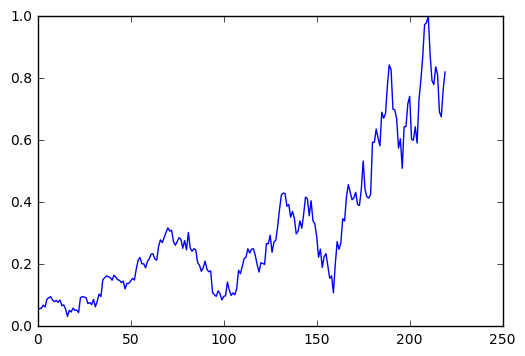

In [473]:
batch = 0 # First sequence in the batch.
signal = 0 # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

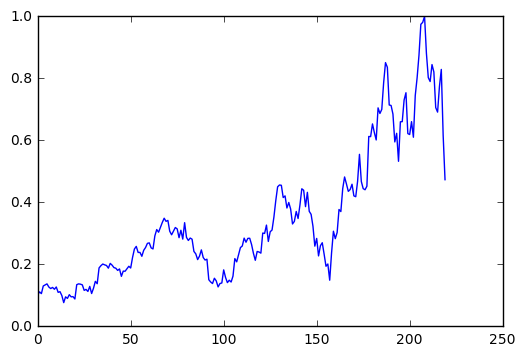

In [474]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

# Validation set

In [475]:
validation_data = (np.expand_dims(x_test_scaled, axis=0), np.expand_dims(y_test_scaled, axis=0))

# Build a LSTM model

In [476]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.python.keras.optimizers import Adagrad
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [477]:
LSTM_model = Sequential()
#LSTM_model.add(LSTM(units=512, return_sequences=True, input_shape=(None, num_x_signals,)))
LSTM_model.add(LSTM(units=220, return_sequences=True, input_shape=(None, num_x_signals,)))
LSTM_model.add(Dense(num_y_signals, activation='sigmoid'))
if False:
    from tensorflow.python.keras.initializers import RandomUniform
    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)
    LSTM_model.add(Dense(num_y_signals, activation='linear', kernel_initializer=init))

## loss function

In [478]:
 warmup_steps = 50
def loss_softmax_cross_entropy_warmup(y_true, y_pred):
    
    # by taking slices of the tensors.
     y_true_slice = y_true[:, warmup_steps:, :]
        y_pred_slice = y_pred[:, warmup_steps:, :]
    
    # Classification 문제이기 때문에 softmax cross-entropy를 쓴다.
     loss = tf.losses.softmax_cross_entropy(onehot_labels=y_true_slice, logits=y_pred_slice )
        loss_mean = tf.reduce_mean(loss)
     return loss_mean


# from sklearn.metrics import r2_score
# import matplotlib.pyplot as plt

# Mean Absolute percentage error
# def mean_absolute_percentage_error(y_true, y_pred):
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

##indicator MAPE
# print(mean_absolute_percentage_error(y_true, y_pred))
# R-squared
# print(r2_score(y_true, y_pred))

# Theil_U
# def Theil_U(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return(np.mean((np.square(y_true - y_pred)))/(np.sqrt(np.mean(np.square(y_true)))+np.sqrt(np.mean(np.square(y_pred)))))

## model compile

In [485]:
from keras import losses
optimizer = Adagrad(lr=1e-3)
LSTM_model.compile(loss='mse', optimizer=optimizer)

In [486]:
LSTM_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, None, 220)         200640    
_________________________________________________________________
dense_9 (Dense)              (None, None, 1)           221       
Total params: 200,861
Trainable params: 200,861
Non-trainable params: 0
_________________________________________________________________


## callback functions for tensorboard

In [487]:
path_checkpoint = '23_checkpoint.keras'
## Recording checkpoints
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)
## If performance in Validation set gets worse, then stop training
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=1)
## 
callback_tensorboard = TensorBoard(log_dir='./logs/SAE_test10',histogram_freq=0,write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_lr=1e-4,patience=0,verbose=1)
callbacks = [callback_early_stopping, callback_checkpoint, callback_tensorboard, callback_reduce_lr]

## Train the model 

In [488]:
%%time
LSTM_model.fit_generator(generator=generator, epochs=20, steps_per_epoch=100, validation_data=validation_data, callbacks=callbacks)

Epoch 1/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0217
Epoch 00001: val_loss improved from inf to 0.26149, saving model to 23_checkpoint.keras
100/100 [==============================] - 41s 411ms/step - loss: 0.0216 - val_loss: 0.2615
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0080
Epoch 00002: val_loss did not improve from 0.26149

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 37s 369ms/step - loss: 0.0080 - val_loss: 0.2811
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0069
Epoch 00003: val_loss did not improve from 0.26149

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [==============================] - 36s 364ms/step - loss: 0.0069 - val_loss: 0.2831
Epoch 4/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0068
Epoch 00004: val_loss did not improve from 0.26149
100/100 [==================

## Read checkpoints when early-stopping occurs

In [489]:
try:
    LSTM_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## Evaluation the model to the test set

In [490]:
result = LSTM_model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 77ms/step


In [491]:
print("loss (test-set):", result)

loss (test-set): 0.26149147748947144


In [492]:
# 만약 여러가지 측정치를 사용한다면 다음의 방법으로 측정할 수 있습니다.
if False:
    for res, metric in zip(result, LSTM_model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

## Visualication of prediction and real values

In [493]:

def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    print("y_train : ", y_train.shape)
    
    # End-index for the sequences.
    end_idx = start_idx + length
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    # Input-signals for the model.
    print("y_true : ", y_true.shape)
    print("x : ", x.shape)
    x = np.expand_dims(x, axis=0)
    print("x : " , x.shape)
    # Use the model to predict the output-signals.
    y_pred = LSTM_model.predict(x)    
    print("y_pred : ", y_pred.shape)

    
    new_y_pred = np.ndarray([100, 3])
    print(new_y_pred.shape)

    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    print("y_pred_rescaled :",y_pred_rescaled.shape)
    # For each output-signal.
    for signal in range(1):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        # Get the true output-signal from the data-set.        
        signal_true = y_true[:, signal]
        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        # Plot labels etc.
        #plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()
    
    print("y_pred type: ",type(y_pred[0]))
    y_pred=y_pred[0].tolist()
   
    
    return y_pred

        

y_train :  (300, 1)
y_true :  (290, 1)
x :  (290, 7)
x :  (1, 290, 7)
y_pred :  (1, 290, 1)
(100, 3)
y_pred_rescaled : (290, 1)


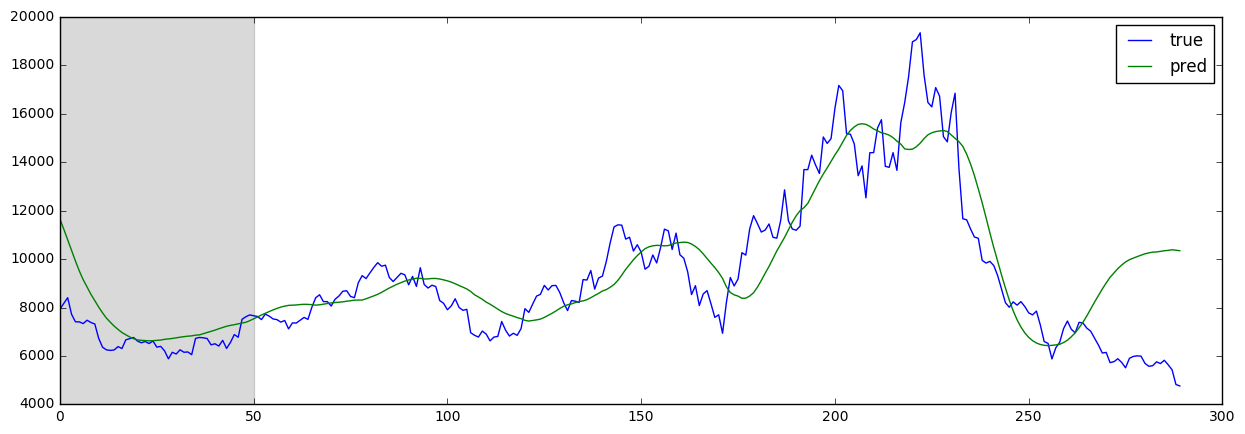

y_pred type:  <class 'numpy.ndarray'>


In [494]:
y_pred_scaled_data=plot_comparison(start_idx=10, length=300, train=True)

y_train :  (300, 1)
y_true :  (200, 1)
x :  (200, 7)
x :  (1, 200, 7)
y_pred :  (1, 200, 1)
(100, 3)
y_pred_rescaled : (200, 1)


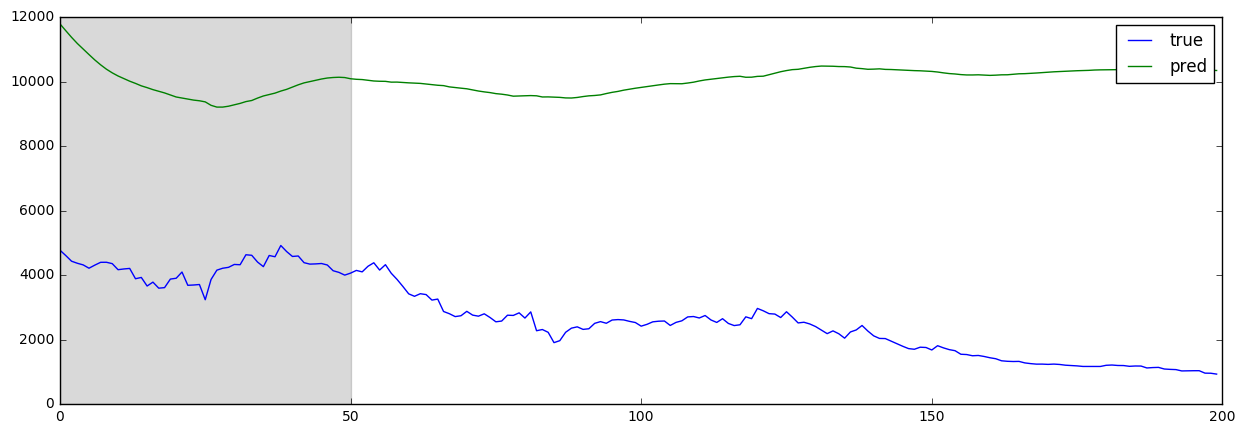

y_pred type:  <class 'numpy.ndarray'>


In [495]:
y_pred_scaled_data=plot_comparison(start_idx=0, length=500, train=False)